# Light GBM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline

In [2]:
def plot_roc(y_true, y_pred, label, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f'{label}: AUC = {roc_auc_score(y_true, y_pred):.4f}')

In [3]:
X_train = pd.read_csv('Data/X_train.csv', index_col='respondent_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='respondent_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='respondent_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='respondent_id')

In [4]:
cat_cols = list(X_train.select_dtypes(include='object').columns)
num_cols = list(X_train.select_dtypes(include=['float64', 'int64']).columns)

In [2]:
def plot_roc(y_true, y_pred, label, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f'{label}: AUC = {roc_auc_score(y_true, y_pred):.4f}')

In [3]:
X_train = pd.read_csv('Data/X_train.csv', index_col='respondent_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='respondent_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='respondent_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='respondent_id')

In [4]:
cat_cols = list(X_train.select_dtypes(include='object').columns)
num_cols = list(X_train.select_dtypes(include=['float64', 'int64']).columns)

### lightgbm0

In [6]:
numeric_preprocessing = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('SimpleImputer', SimpleImputer(strategy='median'))
])

categorical_preprocessing = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy='constant')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

transformer = ColumnTransformer([
    ('numerical', numeric_preprocessing, num_cols),
    ('categorical', categorical_preprocessing, cat_cols)
])

estimator = MultiOutputClassifier(LGBMClassifier(n_jobs=-1, random_state=42))

lightgbm0_pipe = Pipeline([
    ('transformer', transformer),
    ('estimator', estimator)
])

In [7]:
lightgbm0_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('StandardScaler',
                                                                   StandardScaler()),
                                                                  ('SimpleImputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                      

In [22]:
lightgbm0_preds = logreg1_pipe.predict_proba(X_test)

lightgbm0_preds_df = pd.DataFrame({'h1n1_vaccine':logreg1_preds[0][:,1], 'seasonal_vaccine':logreg1_preds[1][:,1]},
                        index=X_test.index)

lightgbm0_score = roc_auc_score(y_test, logreg1_preds_df)
lightgbm0_score

0.8471015887785155

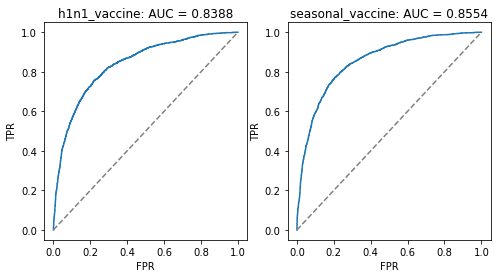

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

plot_roc(y_test.h1n1_vaccine, logreg1_preds_df.h1n1_vaccine, 'h1n1_vaccine', ax[0])
plot_roc(y_test.seasonal_vaccine, logreg1_preds_df.seasonal_vaccine, 'seasonal_vaccine', ax[1])